<a href="https://colab.research.google.com/github/flora0110/podcast_headline_page/blob/main/podcast_to_headline_del_spon_suger_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textsplit

In [1]:
!pip install word2vec

     |████████████████████████████████| 42 kB 633 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156420 sha256=19c10e17d75bd3b4f508d7e19d16b76173d332edb0edc3c3877436b5ed28b6e7
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [2]:
import os
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [3]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

--2022-05-01 14:19:08--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.24
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  3.13MB/s    in 9.5s    

2022-05-01 14:19:18 (3.13 MB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  ./text8.zip
  inflating: text8                   


In [4]:
links = {'podcast_text': 'https://raw.githubusercontent.com/grace-boop/podcast/main/flora_sugar'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

--2022-05-01 14:19:20--  https://raw.githubusercontent.com/grace-boop/podcast/main/flora_sugar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118432 (116K) [text/plain]
Saving to: ‘flora_sugar’

flora_sugar         100%[===================>] 115.66K  --.-KB/s    in 0.003s  

2022-05-01 14:19:20 (37.5 MB/s) - ‘flora_sugar’ saved [118432/118432]



## Train wordvectors

In [5]:
import logging
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
  sentences = word2vec.Text8Corpus('./text8')
  model = word2vec.Word2Vec(sentences, cbow_mean=1, iter=5, hs=1, sample=0.00001, window=15, size=200)

In [6]:
model.save(wrdvec_path)

In [7]:
model = word2vec.Word2Vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.vocab)

## get sentence tokenizer

In [8]:
!pip install textsplit

     |████████████████████████████████| 154 kB 29.6 MB/s 


In [9]:
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [10]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

### podcast

In [11]:
#@title segment target length in sentences { display-mode: "form" }
segment_len =  25#@param {type:"integer"}

penalty 41.73
1218 sentences, 58 segments, avg 21.00 sentences per segment
optimal score 39802.41, greedy score 39715.35
[39802.411241028414, 39715.351322395705]
(39802.411241028414, 39715.351322395705)
ratio of scores 1.0022


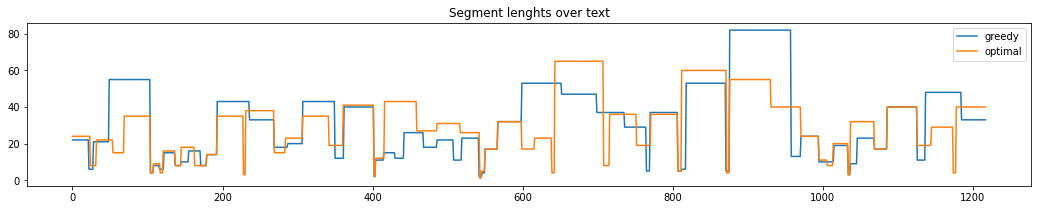

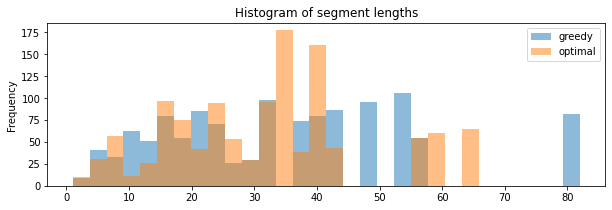

In [12]:
link = links['podcast_text']
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
strs = " "
for i in range(len(sentenced_text)):
  if(sentenced_text[i] != " "):
    strs =sentenced_text[i]
  if(i+1<len(sentenced_text)):
    if(strs == sentenced_text[i+1]):
      sentenced_text[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

#### 顯示分段

In [13]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

['Welcome to the huberman Lab podcast. ', 'We discussed science science basic tools for everyday life. ', "I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. ", 'Today. ', 'We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. ', "We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. ", "One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. ", "I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. ", 'And its various forms is strongly reinforcing. ', 'Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. ', 'Incidentally sweet taste also make us want to eat m

In [14]:
print(sentenced_text)

['Welcome to the huberman Lab podcast. ', 'We discussed science science basic tools for everyday life. ', "I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. ", 'Today. ', 'We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. ', "We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. ", "One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. ", "I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. ", 'And its various forms is strongly reinforcing. ', 'Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. ', 'Incidentally sweet taste also make us want to eat m

### 處理輸入

In [15]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [16]:
print(podcast_test)

["Welcome to the huberman Lab podcast. We discussed science science basic tools for everyday life. I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. Today. We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. And its various forms is strongly reinforcing. Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. Incidentally sweet taste also make us want to eat more of other substances as well. You may

# Headline generator

In [17]:
! pip install transformers datasets

     |████████████████████████████████| 4.0 MB 21.9 MB/s 
     |████████████████████████████████| 325 kB 57.1 MB/s 
     |████████████████████████████████| 6.6 MB 51.0 MB/s 
     |████████████████████████████████| 77 kB 5.7 MB/s 
     |████████████████████████████████| 895 kB 24.4 MB/s 
     |████████████████████████████████| 596 kB 59.7 MB/s 
     |████████████████████████████████| 212 kB 53.1 MB/s 
     |████████████████████████████████| 1.1 MB 37.2 MB/s 
     |████████████████████████████████| 136 kB 43.1 MB/s 
     |████████████████████████████████| 127 kB 42.7 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 144 kB 25.6 MB/s 
     |████████████████████████████████| 271 kB 43.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstallin

In [18]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 31.5 MB/s 


In [19]:
from transformers import pipeline

## 使用Michau/t5-base-en-generate-headline

In [20]:
headlineGenerator = pipeline(model="Michau/t5-base-en-generate-headline", tokenizer="Michau/t5-base-en-generate-headline")

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

In [21]:
#@title 生成標題的長度 { display-mode: "form" }
min_length =  5#@param {type:"integer"}
max_length = 150#@param {type:"integer"}

In [22]:
headlines = headlineGenerator(podcast_test, min_length, max_length)


Ignoring args : (5, 150)
Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors


### 顯示結果

In [23]:
for headline in headlines:
  print(headline)
  print(type(headline))

{'generated_text': 'The Ins and Outs of Sugar and Other Foods Today'}
<class 'dict'>
{'generated_text': 'The Brain Body Contract - Live Event in Seattle, Washington on May 17th and Portland,'}
<class 'dict'>
{'generated_text': 'Nootropics - Is It Really Smart?'}
<class 'dict'>
{'generated_text': 'The Best Supplements For Weight Loss'}
<class 'dict'>
{'generated_text': 'Inside Tracker - A Personal Nutrition Platform That Analyzes Data From Your Blood and'}
<class 'dict'>
{'generated_text': 'Theoretical Principle of More Energy Than We Burn'}
<class 'dict'>
{'generated_text': 'The Brain and Sugar'}
<class 'dict'>
{'generated_text': "Sugar, We're Going to Explore That In The Context Of The Nervous System"}
<class 'dict'>
{'generated_text': 'Sugar and the Hormonal Response to Eating'}
<class 'dict'>
{'generated_text': 'Glucose is Complete Blood Sugar'}
<class 'dict'>
{'generated_text': 'Insulin Response to Clamp Blood Glucose Diabetics'}
<class 'dict'>
{'generated_text': 'Low Carbohydrate 

In [24]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['The Ins and Outs of Sugar and Other Foods Today']
['The Ins and Outs of Sugar and Other Foods Today']
<class 'str'>
['The Brain Body Contract', '-', 'Live Event in Seattle', ',', 'Washington on May 17th and Portland', ',', '']
['The Brain Body Contract', '-', 'Live Event in Seattle', ',', 'Washington on May 17th and Portland', ' ', '']
<class 'str'>
['Nootropics', '-', 'Is It Really Smart?']
['Nootropics', '-', 'Is It Really Smart?']
<class 'str'>
['The Best Supplements For Weight Loss']
['The Best Supplements For Weight Loss']
<class 'str'>
['Inside Tracker', '-', 'A Personal Nutrition Platform That Analyzes Data From Your Blood and']
['Inside Tracker', '-', 'A Personal Nutrition Platform That Analyzes Data From Your Blood and']
<class 'str'>
['Theoretical Principle of More Energy Than We Burn']
['Theoretical Principle of More Energy Than We Burn']
<class 'str'>
['The Brain and Sugar']
['The Brain and Sugar']
<class 'str'>
['Sugar', ',', "We're Going to Explore That In The Context O

In [25]:
for headline_string in headlines_string:
  print(headline_string)

 The Ins and Outs of Sugar and Other Foods Today
 The Brain Body Contract - Live Event in Seattle , Washington on May 17th and Portland 
 Nootropics - Is It Really Smart?
 The Best Supplements For Weight Loss
 Inside Tracker - A Personal Nutrition Platform That Analyzes Data From Your Blood and
 Theoretical Principle of More Energy Than We Burn
 The Brain and Sugar
 Sugar , We're Going to Explore That In The Context Of The Nervous System
 Sugar and the Hormonal Response to Eating
 Glucose is Complete Blood Sugar
 Insulin Response to Clamp Blood Glucose Diabetics
 Low Carbohydrate Diet - Is It Good For Brain Function?
 Ketogenic , I'm a Ketoholic I'm a Ke
 Orientation Tuning in the Visual System
 The Precision of Tuning of Neurons in the Brain is Dependent on Blood Glu
 I'm not super strict about intermittent fasting thing . 
 Glucose is the Favorite Fuel Source for the Nervous System
 The Lower Motor Neurons Are Very Metabolically Demanding
 The Effects of Fructose in Fruits on the Ner

In [26]:
b = "abc, ss dd, www"
a = re.split(r"([,])",b)
print(a)

['abc', ',', ' ss dd', ',', ' www']


# 去掉廣告

In [27]:
!pip install -U scikit-learn
!pip install --user -U nltk

     |████████████████████████████████| 1.5 MB 14.8 MB/s 
     |████████████████████████████████| 749 kB 62.9 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## 使用停使用停用詞(NLTK)

In [29]:
# 下面的代碼是使用nltk從句子中去除停用詞 
# 導入包 
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download("stopwords")
#set(stopwords.words('english')) 
# 例句 
#text = """He determined to drop his litigation with the monastry, and relinguish his claims to the wood-cuting and fishery rihgts at once. He was the more ready to do this becuase the rights had become much less valuable, and he had indeed the vaguest idea where the wood and river in question were.""" 
# 停用詞集合 
stop_words = set(stopwords.words('english')) 
# 分詞 
nltk.download('punkt')
result_nltk = []
for sent in podcast_test:
  word_tokens = word_tokenize(sent) 
  filtered_sentence = [] 
  for w in word_tokens: 
    if w not in stop_words: 
      filtered_sentence.append(w) 
  result_nltk.append(" ".join(filtered_sentence))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [30]:
print(len(result_nltk))
print(result_nltk)

58
["Welcome huberman Lab podcast . We discussed science science basic tools everyday life . I 'm Andrew huberman , I 'm professor neurobiology Ophthalmology Stanford school medicine . Today . We going discuss sugar particular nervous system , regulate , sugar intake seeking sugar . We 're also going discuss sugar regulates nervous system 'll soon , learn sugar really impacts brain body two main mechanism . One mechanisms based Sweet Taste sugar rewarding , even 're much sweet tooth , I confess . I 'm people enjoy sweet taste bitter taste , Sweet Taste sugar . And various forms strongly reinforcing . Meaning triggers activation neurons nerve cells brain body make us want consume sweet substance . Incidentally sweet taste also make us want eat substances well . You may familiar phenomenon . Now sugar also triggers mechanisms brain body based nutritive content independent . Its sweetness . What means actual caloric content way Sugar interacts nervous system subconscious level without awa

In [31]:
vectorizer_nltk = CountVectorizer()
transformer_nltk = TfidfTransformer()
tfidf_nltk = transformer_nltk.fit_transform(vectorizer_nltk.fit_transform(result_nltk))
feature_name_nltk = vectorizer_nltk.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
print(len(feature_name_nltk))
print(feature_name_nltk)

2490
['10', '100', '11', '12', '15', '17th', '18th', '1st', '20', '2012', '30', '3s', '45', '46', '50', '55', '70', '750', '80', '88th', '90', 'ability', 'able', 'absence', 'absolute', 'absolutely', 'abundance', 'abundant', 'accelerator', 'accelerators', 'accept', 'access', 'accident', 'accounting', 'acetylcholine', 'achieve', 'achieving', 'acid', 'acidic', 'acidity', 'acids', 'acknowledge', 'across', 'acting', 'action', 'actionable', 'actions', 'activate', 'activating', 'activation', 'active', 'activities', 'activity', 'actual', 'actually', 'adapted', 'addiction', 'addictive', 'addition', 'additional', 'adhd', 'adjust', 'adjusted', 'adjusting', 'adjustment', 'adrenaline', 'adult', 'adults', 'advanced', 'advantage', 'advantageous', 'affect', 'after', 'ag1', 'again', 'agitated', 'agree', 'agrees', 'ahead', 'aiming', 'alert', 'alkaline', 'alkalinity', 'all', 'allergy', 'allow', 'allowing', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'alter', 'although', 'always', 'am', 'amaz

In [33]:
sponsor_n =0
for i in range(len(feature_name_nltk)):
  if feature_name_nltk[i]=='sponsor':
    sponsor_n =i
    print(i)

2083


In [34]:
# 找出含sponsor的段落內的keyword和其tfidf
from nltk.util import pr
print(type(tfidf_nltk))
keyword_segment = []
tfidf_segment = []
#print(tfidf_nltk)
#print(tfidf_nltk.toarray())
array_tfidf_nltk = tfidf_nltk.toarray()
#print(array_tfidf_nltk)
#print(array_tfidf_nltk[0])
for i in range(len(array_tfidf_nltk)):
  if(array_tfidf_nltk[i][sponsor_n]>0):
    print(i)
    for j in range(len(array_tfidf_nltk[i])):
      if(array_tfidf_nltk[i][j]>0):
        keyword_segment.append(feature_name_nltk[j])
        tfidf_segment.append(array_tfidf_nltk[i][j])
        print(feature_name_nltk[j]," ",array_tfidf_nltk[i][j])

<class 'scipy.sparse.csr.csr_matrix'>
2
ability   0.04505925372287303
accept   0.07372527400348822
access   0.12413945444910941
accounting   0.07372527400348822
acknowledge   0.06690721621241084
alert   0.06690721621241084
all   0.05831747925514211
allow   0.04505925372287303
and   0.08548108046048142
around   0.0466619324762086
artist   0.07372527400348822
asian   0.07372527400348822
based   0.04505925372287303
bees   0.07372527400348822
before   0.06690721621241084
begin   0.07372527400348822
believe   0.16575500830043202
best   0.048433611642399975
biloba   0.07372527400348822
body   0.032656232796195235
brain   0.09864717354664351
bring   0.05041418044562119
called   0.029348470605443055
chemistry   0.07372527400348822
circuits   0.03773920642907592
collection   0.07372527400348822
com   0.05265956416331008
company   0.07372527400348822
confidently   0.07372527400348822
consumer   0.07372527400348822
cost   0.05831747925514211
course   0.07001277139455016
create   0.124139454449109

In [35]:
print(keyword_segment)
print(tfidf_segment)

['ability', 'accept', 'access', 'accounting', 'acknowledge', 'alert', 'all', 'allow', 'and', 'around', 'artist', 'asian', 'based', 'bees', 'before', 'begin', 'believe', 'best', 'biloba', 'body', 'brain', 'bring', 'called', 'chemistry', 'circuits', 'collection', 'com', 'company', 'confidently', 'consumer', 'cost', 'course', 'create', 'creativity', 'day', 'design', 'desire', 'dha', 'different', 'discover', 'drugs', 'effort', 'emphasize', 'essential', 'fail', 'fan', 'far', 'fees', 'first', 'focused', 'functions', 'general', 'genetics', 'ginkgo', 'give', 'goals', 'going', 'highest', 'honest', 'hope', 'however', 'huberman', 'idea', 'ideal', 'if', 'in', 'information', 'ingredients', 'it', 'keeping', 'kit', 'know', 'lab', 'like', 'make', 'makes', 'many', 'math', 'means', 'month', 'months', 'motivated', 'musician', 'need', 'neural', 'nootropic', 'nootropics', 'one', 'our', 'outcomes', 'part', 'particular', 'person', 'phosphatidylserine', 'plans', 'podcast', 'processing', 'public', 'quality', '

In [36]:
# 把含sponsor的後lenth句都作為極有可能是sponaor的區塊
length = 10
sponsor_block = []
for i in range(len(sentenced_text)):
  ws = word_tokenize(sentenced_text[i])
  for w in ws:
    if("sponsor" == w):
      sponsor_block.append(sentenced_text[i])
      for h in range(length):
        if((i+h)<len(sentenced_text)): sponsor_block.append(sentenced_text[i+h])
        
      
sponsor_block = " ".join(sponsor_block)
print(sponsor_block)

Our first sponsor is thesis thesis makes what are called nootropics, which means it's smart.  Our first sponsor is thesis thesis makes what are called nootropics, which means it's smart.  Drugs, be honest.  I'm not a fan of the term nootropics.  I don't believe in smart drugs.  In the sense that I don't believe that there's any one substance, or collection of substances that can make us smarter.  I do believe based on science.  However, that there are particular, neural circuits and brain functions that allow it to be more focused, more alert accept creativity, be more motivated States.  And so the idea of a nootropic that's just going to make us smarter all-around fail, to acknowledge that smarter is many things, right?  If you're an artist or a musician, you're doing math, you're doing accounting a different part of the day you need to be Create a bees are all different.  Brain processing fees understands this. 


In [37]:
# 把sponsor block內的keyword和tdidf記下來
sponsor_word = word_tokenize(sponsor_block)
print(sponsor_word)

keyword_sponsor=[]
tfidf_sponsor=[]
for i in range(len(sponsor_word)):
  if(sponsor_word[i] in keyword_segment and sponsor_word[i] not in keyword_sponsor):
    keyword_sponsor.append(sponsor_word[i])
    tfidf_sponsor.append(tfidf_segment[keyword_segment.index(sponsor_word[i])])
print(len(keyword_sponsor))
print(len(tfidf_sponsor))
n = len(keyword_sponsor)
for i in range(n):
  for j in range(0,n-i-1):
    
    if(tfidf_sponsor[j]>tfidf_sponsor[j+1]):
      tfidf_sponsor[j], tfidf_sponsor[j+1] =  tfidf_sponsor[j+1], tfidf_sponsor[j]
      keyword_sponsor[j], keyword_sponsor[j+1] =  keyword_sponsor[j+1], keyword_sponsor[j]
for i in range(0,n):
  print(keyword_sponsor[i]," ",tfidf_sponsor[i])

['Our', 'first', 'sponsor', 'is', 'thesis', 'thesis', 'makes', 'what', 'are', 'called', 'nootropics', ',', 'which', 'means', 'it', "'s", 'smart', '.', 'Our', 'first', 'sponsor', 'is', 'thesis', 'thesis', 'makes', 'what', 'are', 'called', 'nootropics', ',', 'which', 'means', 'it', "'s", 'smart', '.', 'Drugs', ',', 'be', 'honest', '.', 'I', "'m", 'not', 'a', 'fan', 'of', 'the', 'term', 'nootropics', '.', 'I', 'do', "n't", 'believe', 'in', 'smart', 'drugs', '.', 'In', 'the', 'sense', 'that', 'I', 'do', "n't", 'believe', 'that', 'there', "'s", 'any', 'one', 'substance', ',', 'or', 'collection', 'of', 'substances', 'that', 'can', 'make', 'us', 'smarter', '.', 'I', 'do', 'believe', 'based', 'on', 'science', '.', 'However', ',', 'that', 'there', 'are', 'particular', ',', 'neural', 'circuits', 'and', 'brain', 'functions', 'that', 'allow', 'it', 'to', 'be', 'more', 'focused', ',', 'more', 'alert', 'accept', 'creativity', ',', 'be', 'more', 'motivated', 'States', '.', 'And', 'so', 'the', 'idea',

## 篩選出名詞和形容詞

In [38]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
def preprocess(sent):
    sent = nltk.pos_tag(sent)
    return sent
part = preprocess(keyword_sponsor)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [39]:
select_word = []
#part = part.reverse()
for i in range(len(part)):
  if(part[i][1]=='NN' or part[i][1]=='NNS' or part[i][1]=='JJ'or part[i][1]=='JJR'):
    select_word.append(part[i][0])

In [40]:
select_word

['neural',
 'many',
 'circuits',
 'right',
 'means',
 'sense',
 'substance',
 'day',
 'idea',
 'things',
 'substances',
 'term',
 'functions',
 'alert',
 'nootropic',
 'fail',
 'sponsor',
 'fan',
 'collection',
 'creativity',
 'artist',
 'musician',
 'math',
 'accounting',
 'bees',
 'fees',
 'understands',
 'first',
 'brain',
 'part',
 'drugs',
 'different',
 'science',
 'thesis',
 'smarter',
 'nootropics']

## 去掉sponsor

In [41]:
for i in range(len(sentenced_text)):
  matches = [a for a in select_word if a in sentenced_text[i]]
  #print(all_sentence[i])
  print(matches)

[]
['day', 'science']
[]
['day']
['part']
['brain']
[]
[]
[]
['substance', 'brain']
['substance', 'substances']
[]
['brain']
[]
['means', 'day']
['term', 'brain']
[]
['brain', 'part']
[]
['day']
[]
[]
['brain']
[]
[]
[]
[]
['part', 'science']
[]
[]
[]
[]
[]
[]
[]
['part', 'science']
['day', 'sponsor']
['means', 'nootropic', 'sponsor', 'first', 'thesis', 'nootropics']
[]
['term', 'nootropic', 'fan', 'nootropics']
['drugs']
['sense', 'substance', 'substances', 'collection', 'smarter']
['science']
['neural', 'circuits', 'functions', 'alert', 'creativity', 'brain', 'part']
['many', 'right', 'idea', 'things', 'nootropic', 'fail', 'smarter']
['day', 'artist', 'musician', 'math', 'accounting', 'bees', 'part', 'different']
['fees', 'understands']
['nootropic', 'first', 'nootropics']
[]
['things']
['nootropic', 'brain', 'different', 'nootropics']
['idea', 'nootropic', 'brain', 'different', 'nootropics']
[]
['thesis']
[]
[]
[]
['first', 'different']
[]
['first']
['day']
[]
[]
[]
['sponsor']
[]
[

In [42]:
num = 5
match_num=1
before_flag = [0]*num
is_sponsor = []
for i in range(len(sentenced_text)):
  if("sponsor" in sentenced_text[i]):
    
    for j in range(i,len(sentenced_text)):
      matches = [a for a in select_word if a in sentenced_text[j]]
      
      for f in range(num-1,0,-1):
        before_flag[f] = before_flag[f-1]
      if(len(matches)>match_num or i==j): before_flag[0] = 1
      else: before_flag[0] = 0
      print(before_flag)
      flag=0
      for f in range(num):
        if(before_flag[f]==1): 
          flag=1
          break
      if(flag==1):
        if((j-num-1)>=i): is_sponsor.append(sentenced_text[j-num-1])
        
      else:
        is_sponsor.append("----------------------------------------------------------------")
        break
    break

[1, 0, 0, 0, 0]
[1, 1, 0, 0, 0]
[0, 1, 1, 0, 0]
[1, 0, 1, 1, 0]
[0, 1, 0, 1, 1]
[1, 0, 1, 0, 1]
[0, 1, 0, 1, 0]
[1, 0, 1, 0, 1]
[1, 1, 0, 1, 0]
[1, 1, 1, 0, 1]
[1, 1, 1, 1, 0]
[1, 1, 1, 1, 1]
[0, 1, 1, 1, 1]
[0, 0, 1, 1, 1]
[1, 0, 0, 1, 1]
[1, 1, 0, 0, 1]
[0, 1, 1, 0, 0]
[0, 0, 1, 1, 0]
[0, 0, 0, 1, 1]
[0, 0, 0, 0, 1]
[0, 0, 0, 0, 0]


In [43]:
for sent in is_sponsor: 
  print(sent)

I'd like to thank the sponsors of today's podcast. 
Our first sponsor is thesis thesis makes what are called nootropics, which means it's smart. 
Drugs, be honest. 
I'm not a fan of the term nootropics. 
I don't believe in smart drugs. 
In the sense that I don't believe that there's any one substance, or collection of substances that can make us smarter. 
I do believe based on science. 
However, that there are particular, neural circuits and brain functions that allow it to be more focused, more alert accept creativity, be more motivated States. 
And so the idea of a nootropic that's just going to make us smarter all-around fail, to acknowledge that smarter is many things, right? 
If you're an artist or a musician, you're doing math, you're doing accounting a different part of the day you need to be Create a bees are all different. 
Brain processing fees understands this. 
And as far as I know that the first nootropics company to create Target in nootropics for specific outcomes. 
The 

In [44]:
del_sponsor_sentence = []
for i in range(len(sentenced_text)):
  if (sentenced_text[i] not in is_sponsor):
    del_sponsor_sentence.append(sentenced_text[i])
for sent in del_sponsor_sentence: 
  print(sent)

Welcome to the huberman Lab podcast. 
We discussed science science basic tools for everyday life. 
I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. 
Today. 
We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. 
We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. 
One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. 
I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. 
And its various forms is strongly reinforcing. 
Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. 
Incidentally sweet taste also make us want to eat more of other substances as well.

# 重新來分段一次

143.36348209634204
penalty 65.39
1204 sentences, 12 segments, avg 100.33 sentences per segment
optimal score 38894.11, greedy score 38865.47
[38894.10787241139, 38865.46818084181]
(38894.10787241139, 38865.46818084181)
ratio of scores 1.0007


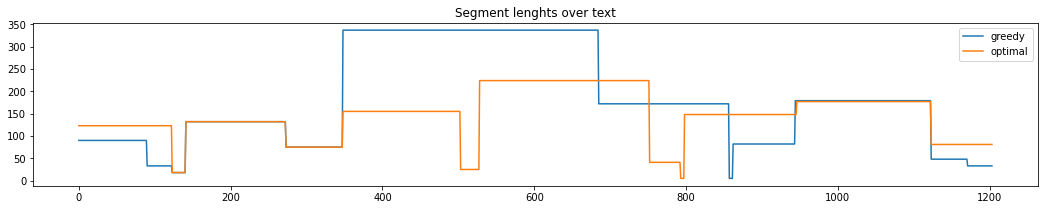

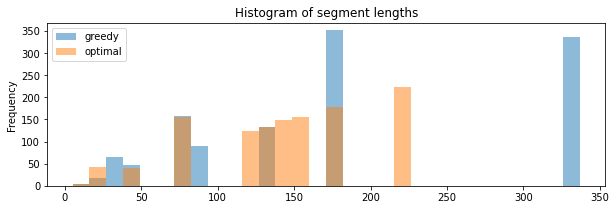

In [45]:
strs = " "
for i in range(len(del_sponsor_sentence)):
  if(del_sponsor_sentence[i] != " "):
    strs =del_sponsor_sentence[i]
  if(i+1<len(del_sponsor_sentence)):
    if(strs == del_sponsor_sentence[i+1]):
      del_sponsor_sentence[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(del_sponsor_sentence).dot(wrdvecs)
new_length = len(del_sponsor_sentence)**0.7
print(new_length)
penalty = get_penalty([sentence_vectors], new_length)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(del_sponsor_sentence, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(del_sponsor_sentence), len(segmented_text), len(del_sponsor_sentence) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(del_sponsor_sentence, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

In [46]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

['Welcome to the huberman Lab podcast. ', 'We discussed science science basic tools for everyday life. ', "I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. ", 'Today. ', 'We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. ', "We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. ", "One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. ", "I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. ", 'And its various forms is strongly reinforcing. ', 'Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. ', 'Incidentally sweet taste also make us want to eat m

In [47]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [48]:
headlines = headlineGenerator(podcast_test, min_length, max_length)

Ignoring args : (5, 150)


In [49]:
for headline in headlines:
  print(headline)
  

{'generated_text': 'The Brain and the Body - The Brain and the Brain'}
{'generated_text': 'Type 1 Diabetes - How to Clamp Blood Glucose Levels'}
{'generated_text': 'The Importance of Glucose in the Nervous System'}
{'generated_text': 'Is Fructose a Good Thing?'}
{'generated_text': 'Dopamine and the Pleasure Pain - The Secret of the Mood and'}
{'generated_text': 'The Preference for Sweet Taste in Foods'}
{'generated_text': 'The Effects of Sugary Foods on Your Blood Sugar'}
{'generated_text': 'Is There a Conversion of Artificial Sweeteners?'}
{'generated_text': 'Is That a Fair Experiment Or Is It Not Our Natural World Experi'}
{'generated_text': 'ADHD and the Effects of Sugar Consumption'}
{'generated_text': 'The Secret of Managing Blood Glucose'}
{'generated_text': 'The Importance of Sleep in the Brain and Body'}


In [50]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['The Brain and the Body', '-', 'The Brain and the Brain']
['The Brain and the Body', '-', 'The Brain and the Brain']
<class 'str'>
['Type 1 Diabetes', '-', 'How to Clamp Blood Glucose Levels']
['Type 1 Diabetes', '-', 'How to Clamp Blood Glucose Levels']
<class 'str'>
['The Importance of Glucose in the Nervous System']
['The Importance of Glucose in the Nervous System']
<class 'str'>
['Is Fructose a Good Thing?']
['Is Fructose a Good Thing?']
<class 'str'>
['Dopamine and the Pleasure Pain', '-', 'The Secret of the Mood and']
['Dopamine and the Pleasure Pain', '-', 'The Secret of the Mood and']
<class 'str'>
['The Preference for Sweet Taste in Foods']
['The Preference for Sweet Taste in Foods']
<class 'str'>
['The Effects of Sugary Foods on Your Blood Sugar']
['The Effects of Sugary Foods on Your Blood Sugar']
<class 'str'>
['Is There a Conversion of Artificial Sweeteners?']
['Is There a Conversion of Artificial Sweeteners?']
<class 'str'>
['Is That a Fair Experiment Or Is It Not Our N

In [51]:
for headline_string in headlines_string:
  print(headline_string)

 The Brain and the Body - The Brain and the Brain
 Type 1 Diabetes - How to Clamp Blood Glucose Levels
 The Importance of Glucose in the Nervous System
 Is Fructose a Good Thing?
 Dopamine and the Pleasure Pain - The Secret of the Mood and
 The Preference for Sweet Taste in Foods
 The Effects of Sugary Foods on Your Blood Sugar
 Is There a Conversion of Artificial Sweeteners?
 Is That a Fair Experiment Or Is It Not Our Natural World Experi
 ADHD and the Effects of Sugar Consumption
 The Secret of Managing Blood Glucose
 The Importance of Sleep in the Brain and Body


In [52]:
len(headlines_string)

12

In [53]:
print(headlines_string)
3

[' The Brain and the Body - The Brain and the Brain', ' Type 1 Diabetes - How to Clamp Blood Glucose Levels', ' The Importance of Glucose in the Nervous System', ' Is Fructose a Good Thing?', ' Dopamine and the Pleasure Pain - The Secret of the Mood and', ' The Preference for Sweet Taste in Foods', ' The Effects of Sugary Foods on Your Blood Sugar', ' Is There a Conversion of Artificial Sweeteners?', ' Is That a Fair Experiment Or Is It Not Our Natural World Experi', ' ADHD and the Effects of Sugar Consumption', ' The Secret of Managing Blood Glucose', ' The Importance of Sleep in the Brain and Body']


3

In [54]:
first_sentence = []
for i in range(len(segmented_text)):
  first_sentence.append(segmented_text[i][0].strip().rstrip().rstrip('.'))
  print(segmented_text[i][0])
  print(type(segmented_text[i][0]))
  print(len(segmented_text[i]))

Welcome to the huberman Lab podcast. 
<class 'str'>
123
So it's a very logical system. 
<class 'str'>
18
Meaning it's Peaks and it's valleys are more like Smooth it out and that glucose is sequestered. 
<class 'str'>
132
Fructose, of course, is found in fruit. 
<class 'str'>
75
That your body is more efficient at using circulating blood sugar, its able to store that use that for fuel. 
<class 'str'>
155
I'll provide a link to this study in the caption first. 
<class 'str'>
25
In fact, the way these experiments are done is very clever. 
<class 'str'>
224
What they do is they have people and He studies were done in people and just multi dextrin, which increases blood glucose doesn't have much flavor, but even if it Does have a little bit of subtle flavor. 
<class 'str'>
41
So, that's not really a fair experiment or it's not our natural world experiment. 
<class 'str'>
5
They're experiencing these odd shifts in insula. 
<class 'str'>
148
Some of you with three. 
<class 'str'>
177
We have 

In [55]:
print(first_sentence)
print(len((first_sentence)))

['Welcome to the huberman Lab podcast', "So it's a very logical system", "Meaning it's Peaks and it's valleys are more like Smooth it out and that glucose is sequestered", 'Fructose, of course, is found in fruit', 'That your body is more efficient at using circulating blood sugar, its able to store that use that for fuel', "I'll provide a link to this study in the caption first", 'In fact, the way these experiments are done is very clever', "What they do is they have people and He studies were done in people and just multi dextrin, which increases blood glucose doesn't have much flavor, but even if it Does have a little bit of subtle flavor", "So, that's not really a fair experiment or it's not our natural world experiment", "They're experiencing these odd shifts in insula", 'Some of you with three', 'We have a newsletter the brought tools and how to maximize sleep']
12
